# Heatwave Frequency Analysis Notebook

In this notebook, we analyze the output of the heatwave frequency code. We have four distinct subsections. 

In **Import data** we import and parse the data from our runs.

In **Compute stats** we compute the statistics (mean, variance, skewness) of the daily mean temperature, daily max temperature, and daily mean soil moisture fraction. 

In ***Z*-based plots** we plot the aforecomputed stats against *Z* to measure how these quantities will change with a change in climate.

In **Histograms and PDFs** we plot raw histograms of daily mean temperature, daily max temperature, and daily mean soil moisture. We also estimate their PDFs with kernel density estimation. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import xarray as xr 
import glob 
import matplotlib as mpl 
from scipy.stats import skew, gaussian_kde

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

# general plot parameters
color_list = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#CC79A7']
marker_list = ['o', 's', 'P', '+', 'D', 'v', '3']
fontsize = 22
labelsize = 20
markersize = 8
figsize = (16, 10)

## Import data

We import simulation result data here and parse each data variable into its own list.

In [2]:
sim_result_path = "/data/keeling/a/adammb4/heatwaves-physics/data/heatwave-freq-data/"
sim_result_filenames = glob.glob(''.join([sim_result_path, '3-4-2022-*-full-*']))
N_files = len(sim_result_filenames)
sim_result_filenames.sort()
sim_result_filenames

['/data/keeling/a/adammb4/heatwaves-physics/data/heatwave-freq-data/3-4-2022-ATL-full-exc_perc.nc',
 '/data/keeling/a/adammb4/heatwaves-physics/data/heatwave-freq-data/3-4-2022-DAL-full-exc_perc.nc',
 '/data/keeling/a/adammb4/heatwaves-physics/data/heatwave-freq-data/3-4-2022-NY-full-exc_perc.nc',
 '/data/keeling/a/adammb4/heatwaves-physics/data/heatwave-freq-data/3-4-2022-SEA-full-exc_perc.nc',
 '/data/keeling/a/adammb4/heatwaves-physics/data/heatwave-freq-data/3-4-2022-SGP-full-exc_perc.nc',
 '/data/keeling/a/adammb4/heatwaves-physics/data/heatwave-freq-data/3-4-2022-WIT-full-exc_perc.nc']

In [3]:
file_list = ["ATL", "DAL", "NY", "SEA", "SGP", "WIT"]
ds = xr.open_dataset(sim_result_filenames[1])
ds # example dataset

<xarray.Dataset>
Dimensions:          (F: 10, day: 2070)
Coordinates:
  * F                (F) float64 0.0 13.66 27.32 40.98 ... 95.62 109.3 122.9
  * day              (day) int64 0 1 2 3 4 5 6 ... 2064 2065 2066 2067 2068 2069
Data variables:
    mean_Z           (F) float64 ...
    Tmax_ex_dyn      (F) float64 ...
    Tdaily_ex_dyn    (F) float64 ...
    Tmax_ex_stat     (F) float64 ...
    Tdaily_ex_stat   (F) float64 ...
    mdaily_ex        (F) float64 ...
    Tmax_95perc      (F) float64 ...
    Tdaily_95perc    (F) float64 ...
    mdaily_5perc     (F) float64 ...
    Tmax_mean_sim    (F) float64 ...
    Tdaily_mean_sim  (F) float64 ...
    mdaily_mean_sim  (F) float64 ...
    Tdaily_mean      (F, day) float64 ...
    Tmax_daily       (F, day) float64 ...
    mdaily_mean      (F, day) float64 ...

In [4]:
# Zs
Zs = [xr.open_dataset(sim_result_filenames[file])["mean_Z"].values for file in range(0, N_files)]

# exceedences
Tmax_exs_dyn = [xr.open_dataset(sim_result_filenames[file])["Tmax_ex_dyn"].values for file in range(0, N_files)]
Tdaily_exs_dyn = [xr.open_dataset(sim_result_filenames[file])["Tdaily_ex_dyn"].values for file in range(0, N_files)]
mdaily_exs = [xr.open_dataset(sim_result_filenames[file])["mdaily_ex"].values for file in range(0, N_files)]
Tmax_exs_stat = [xr.open_dataset(sim_result_filenames[file])["Tmax_ex_stat"].values for file in range(0, N_files)]
Tdaily_exs_stat = [xr.open_dataset(sim_result_filenames[file])["Tdaily_ex_stat"].values for file in range(0, N_files)]

# percentiles 
Tmax_95percs = [xr.open_dataset(sim_result_filenames[file])["Tmax_95perc"].values for file in range(0, N_files)]
Tdaily_95percs = [xr.open_dataset(sim_result_filenames[file])["Tdaily_95perc"].values for file in range(0, N_files)]
mdaily_5percs = [xr.open_dataset(sim_result_filenames[file])["mdaily_5perc"].values for file in range(0, N_files)]

# full simulation means
Tmax_means = [xr.open_dataset(sim_result_filenames[file])["Tmax_mean_sim"].values for file in range(0, N_files)]
Tdaily_means = [xr.open_dataset(sim_result_filenames[file])["Tdaily_mean_sim"].values for file in range(0, N_files)]
mdaily_means = [xr.open_dataset(sim_result_filenames[file])["mdaily_mean_sim"].values for file in range(0, N_files)]

# daily values
Tmax_daily = [xr.open_dataset(sim_result_filenames[file])["Tmax_daily"].values for file in range(0, N_files)]
Tdaily_daily = [xr.open_dataset(sim_result_filenames[file])["Tdaily_mean"].values for file in range(0, N_files)]
mdaily_daily = [xr.open_dataset(sim_result_filenames[file])["mdaily_mean"].values for file in range(0, N_files)]

## Compute stats

Here we compute some relevant statistics of daily mean values, as a function of the radiative forcing increase.

In [5]:
Tmax_mean = [np.mean(Tmax_daily[file], axis=1) for file in range(N_files)]
Tmax_std = [np.std(Tmax_daily[file], axis=1) for file in range(N_files)]
Tmax_skew = [skew(Tmax_daily[file], axis=1) for file in range(N_files)]

Tdaily_mean = [np.mean(Tdaily_daily[file], axis=1) for file in range(N_files)]
Tdaily_std = [np.std(Tdaily_daily[file], axis=1) for file in range(N_files)]
Tdaily_skew = [skew(Tdaily_daily[file], axis=1) for file in range(N_files)]

mdaily_mean = [np.mean(mdaily_daily[file], axis=1) for file in range(N_files)]
mdaily_std = [np.std(mdaily_daily[file], axis=1) for file in range(N_files)]
mdaily_skew = [skew(mdaily_daily[file], axis=1) for file in range(N_files)]

## $\mathcal{Z}$ Plots

Here we make plots of exceedence percentage and statistics against $\mathcal{Z}$.

### Exceedence Plots

#### Static baseline

These are plots of the percentage of days which exceed the base case 95th percentile in temperature, and fail to exceed the 5th percentile in base case daily mean soil moisture fraction. 

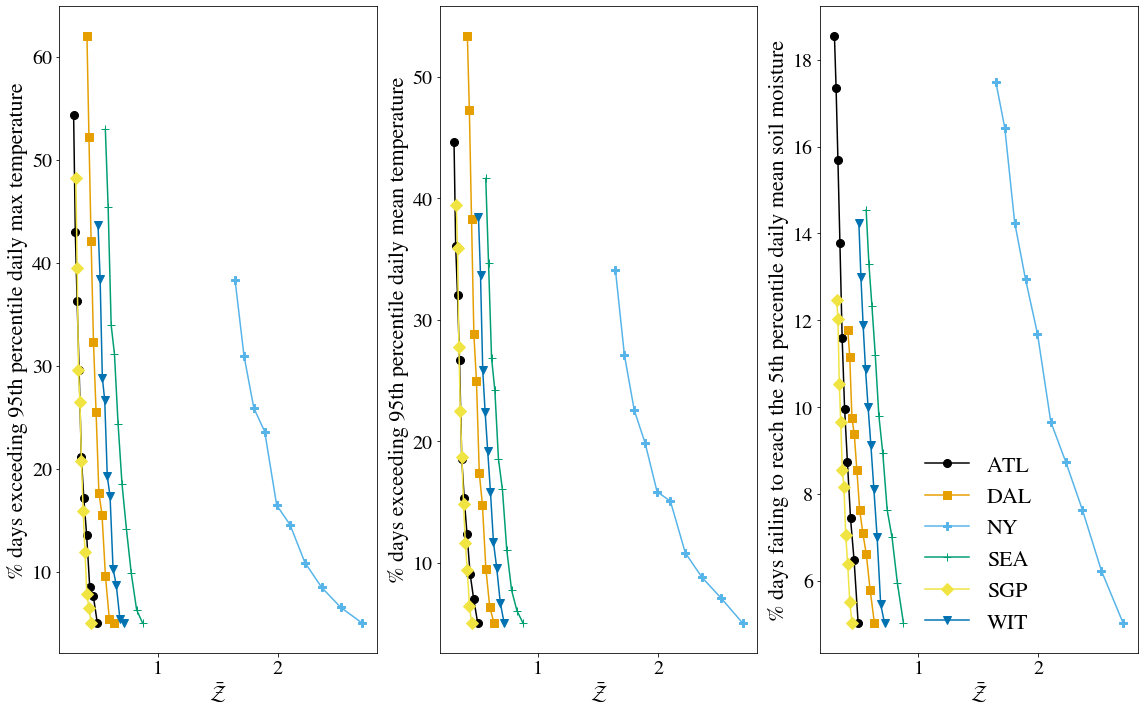

In [6]:
fig, ax = plt.subplots(1, 3, figsize=figsize)

for file in range(N_files):
    ax[0].plot(Zs[file], Tmax_exs_stat[file], color=color_list[file], marker=marker_list[file], markersize = markersize, label=file_list[file])
    ax[1].plot(Zs[file], Tdaily_exs_stat[file], color=color_list[file], marker=marker_list[file], markersize = markersize, label=file_list[file])
    ax[2].plot(Zs[file], mdaily_exs[file], color=color_list[file], marker=marker_list[file], markersize = markersize, label=file_list[file])
    
ax[0].set_ylabel("% days exceeding 95th percentile daily max temperature", fontsize=fontsize)
ax[1].set_ylabel("% days exceeding 95th percentile daily mean temperature", fontsize=fontsize)
ax[2].set_ylabel("% days failing to reach the 5th percentile daily mean soil moisture", fontsize=fontsize)
ax[2].legend(frameon=False, fontsize=fontsize)

for plot in range(0, 3):
    ax[plot].tick_params(axis='both', labelsize=labelsize)
    ax[plot].set_xlabel(r"$\bar{\mathcal{Z}}$", fontsize=fontsize)
    
fig.tight_layout()

#### Log $\mathcal{Z}$ scale

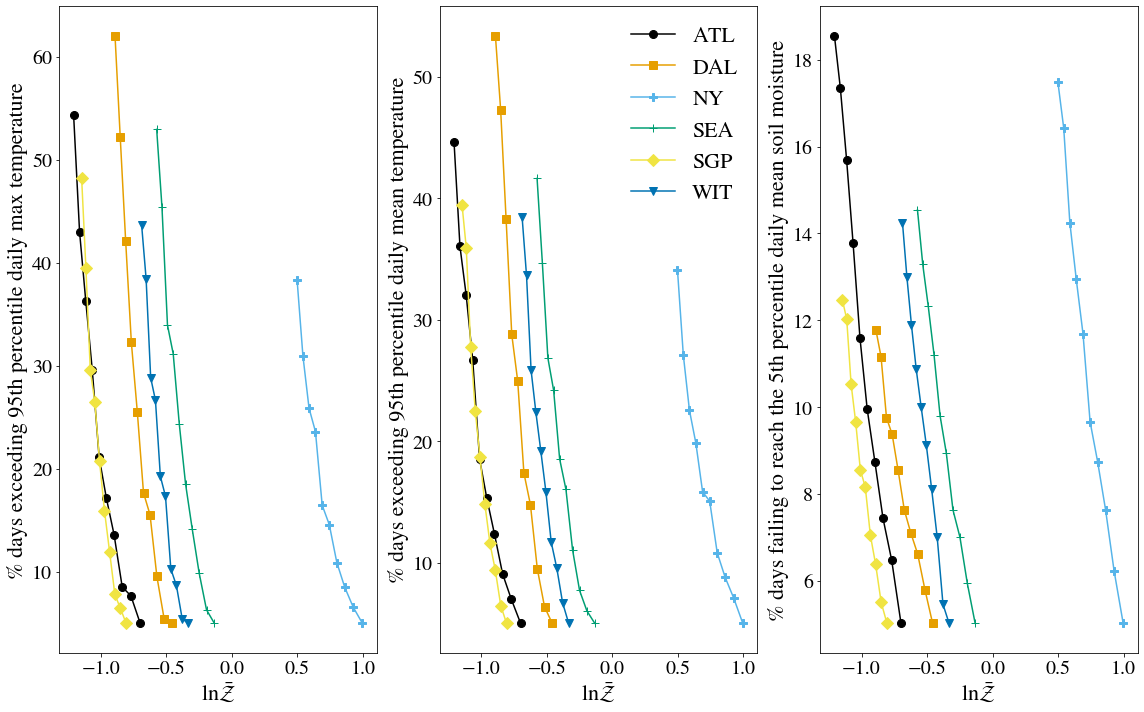

In [7]:
fig, ax = plt.subplots(1, 3, figsize=figsize)

for file in range(N_files):
    ax[0].plot(np.log(Zs[file]), Tmax_exs_stat[file], color=color_list[file], marker=marker_list[file], markersize = markersize, label=file_list[file])
    ax[1].plot(np.log(Zs[file]), Tdaily_exs_stat[file], color=color_list[file], marker=marker_list[file], markersize = markersize, label=file_list[file])
    ax[2].plot(np.log(Zs[file]), mdaily_exs[file], color=color_list[file], marker=marker_list[file], markersize = markersize, label=file_list[file])
    
ax[0].set_ylabel("% days exceeding 95th percentile daily max temperature", fontsize=fontsize)
ax[1].set_ylabel("% days exceeding 95th percentile daily mean temperature", fontsize=fontsize)
ax[2].set_ylabel("% days failing to reach the 5th percentile daily mean soil moisture", fontsize=fontsize)
ax[1].legend(frameon=False, fontsize=fontsize)

for plot in range(0, 3):
    ax[plot].tick_params(axis='both', labelsize=labelsize)
    ax[plot].set_xlabel(r"$\ln\bar{\mathcal{Z}}$", fontsize=fontsize)
    
fig.tight_layout()

### Dynamic baseline

Same as above, but now in the temperature simulation we increment the baseline by the amount of expected global warming. The soil moisture plot remains the same.

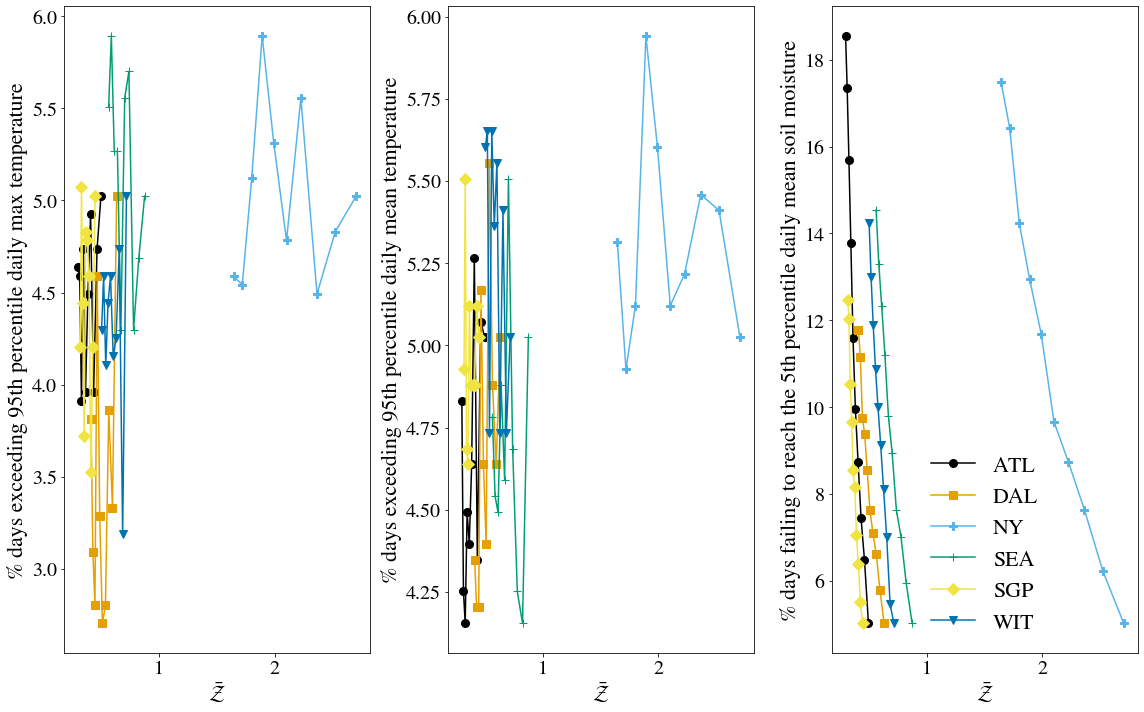

In [8]:
fig, ax = plt.subplots(1, 3, figsize=figsize)

for file in range(N_files):
    ax[0].plot(Zs[file], Tmax_exs_dyn[file], color=color_list[file], marker=marker_list[file], markersize = markersize, label=file_list[file])
    ax[1].plot(Zs[file], Tdaily_exs_dyn[file], color=color_list[file], marker=marker_list[file], markersize = markersize, label=file_list[file])
    ax[2].plot(Zs[file], mdaily_exs[file], color=color_list[file], marker=marker_list[file], markersize = markersize, label=file_list[file])
    
ax[0].set_ylabel("% days exceeding 95th percentile daily max temperature", fontsize=fontsize)
ax[1].set_ylabel("% days exceeding 95th percentile daily mean temperature", fontsize=fontsize)
ax[2].set_ylabel("% days failing to reach the 5th percentile daily mean soil moisture", fontsize=fontsize)
ax[2].legend(frameon=False, fontsize=fontsize)

for plot in range(0, 3):
    ax[plot].tick_params(axis='both', labelsize=labelsize)
    ax[plot].set_xlabel(r"$\bar{\mathcal{Z}}$", fontsize=fontsize)
    
fig.tight_layout()

#### Log $\cal{Z}$ scale

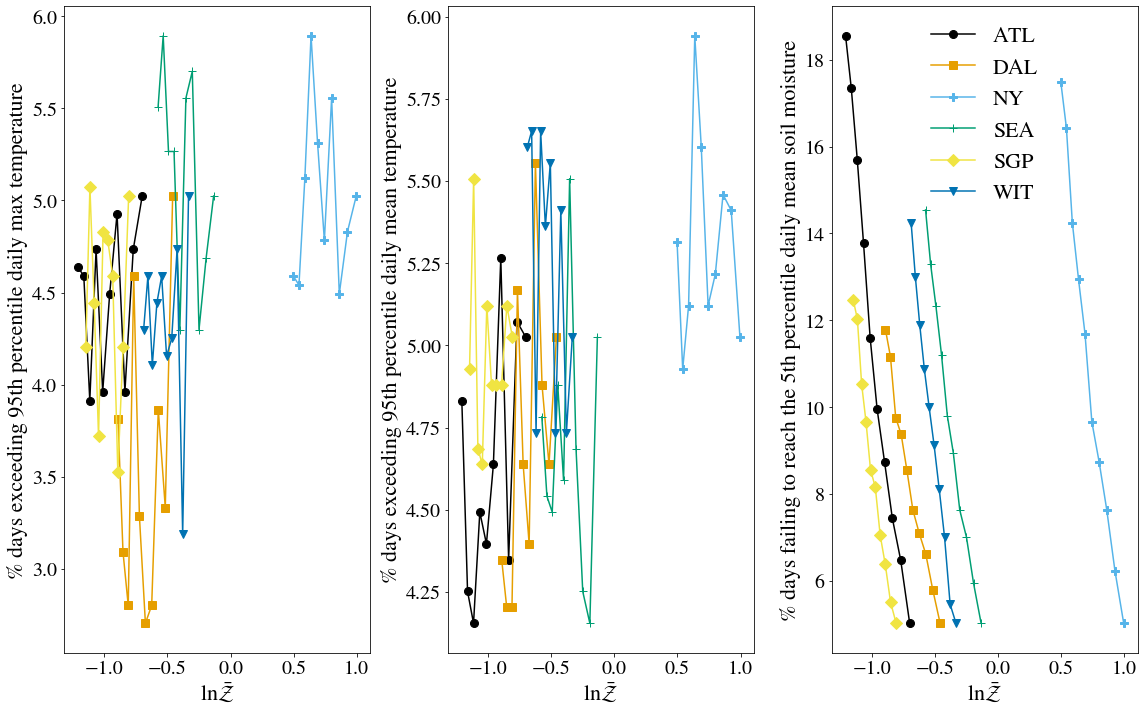

In [9]:
fig, ax = plt.subplots(1, 3, figsize=figsize)

for file in range(0, N_files):
    ax[0].plot(np.log(Zs[file]), Tmax_exs_dyn[file], color=color_list[file], marker=marker_list[file], markersize = markersize, label=file_list[file])
    ax[1].plot(np.log(Zs[file]), Tdaily_exs_dyn[file], color=color_list[file], marker=marker_list[file], markersize = markersize, label=file_list[file])
    ax[2].plot(np.log(Zs[file]), mdaily_exs[file], color=color_list[file], marker=marker_list[file], markersize = markersize, label=file_list[file])
    
ax[0].set_ylabel("% days exceeding 95th percentile daily max temperature", fontsize=fontsize)
ax[1].set_ylabel("% days exceeding 95th percentile daily mean temperature", fontsize=fontsize)
ax[2].set_ylabel("% days failing to reach the 5th percentile daily mean soil moisture", fontsize=fontsize)
ax[2].legend(frameon=False, fontsize=fontsize)

for plot in range(0, 3):
    ax[plot].tick_params(axis='both', labelsize=labelsize)
    ax[plot].set_xlabel(r"$\ln\bar{\mathcal{Z}}$", fontsize=fontsize)
    
fig.tight_layout()

### Side-by-side comparison

Compare, side-by-side, the dynamic baseline and the static baseline simulations for each location.

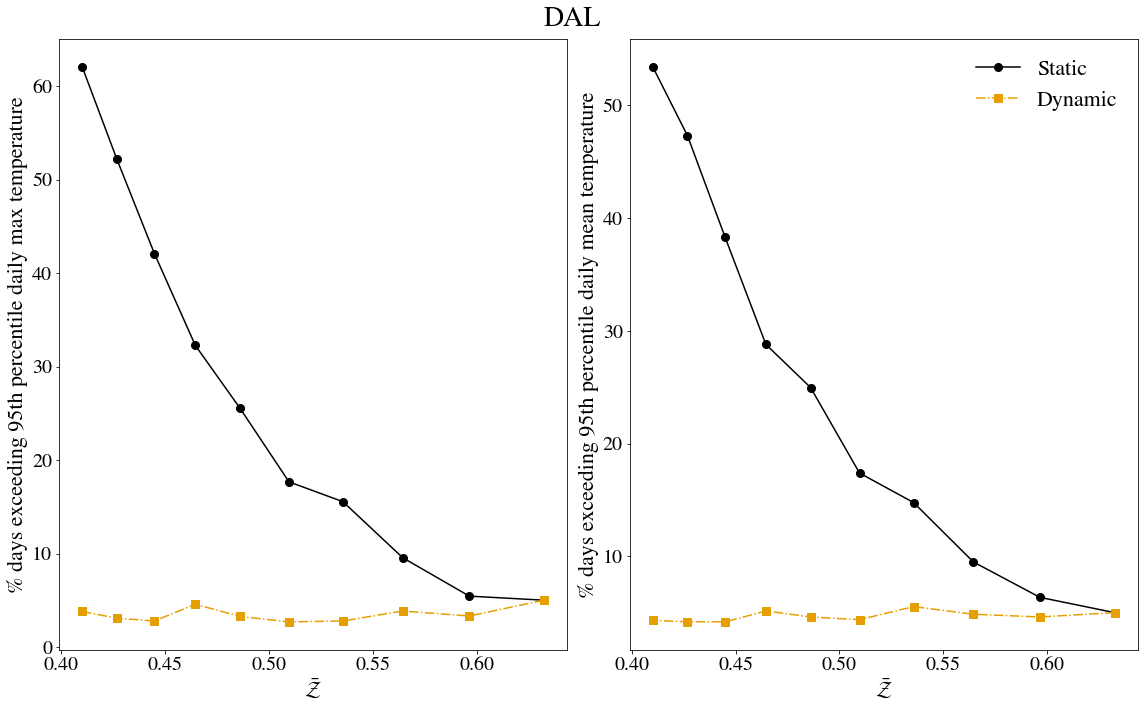

In [10]:
# location index: index of location (Follow file_list)

file_num = 1

fig, ax = plt.subplots(1,2, figsize=figsize, sharex=True, sharey=False)

ax[0].plot(Zs[file_num], Tmax_exs_stat[file_num], marker=marker_list[0], markersize = markersize, linestyle='solid', color=color_list[0], label="Static")
ax[0].plot(Zs[file_num], Tmax_exs_dyn[file_num], marker=marker_list[1], markersize = markersize, linestyle='dashdot', color=color_list[1], label="Dynamic")

ax[1].plot(Zs[file_num], Tdaily_exs_stat[file_num], marker=marker_list[0], markersize = markersize, linestyle='solid', color=color_list[0], label="Static")
ax[1].plot(Zs[file_num], Tdaily_exs_dyn[file_num], marker=marker_list[1], markersize = markersize, linestyle='dashdot', color=color_list[1], label="Dynamic")
fig.suptitle(file_list[file_num], fontsize=fontsize+6)
ax[1].legend(frameon=False, fontsize=fontsize)
ax[0].set_ylabel("% days exceeding 95th percentile daily max temperature", fontsize=fontsize)
ax[1].set_ylabel("% days exceeding 95th percentile daily mean temperature", fontsize=fontsize)

for i in range(0,2):
    ax[i].tick_params(axis="both", labelsize=labelsize)
    ax[i].set_xlabel(r"$\bar{\mathcal{Z}}$", fontsize=fontsize)
    
fig.tight_layout()

#### Log Z x-axis

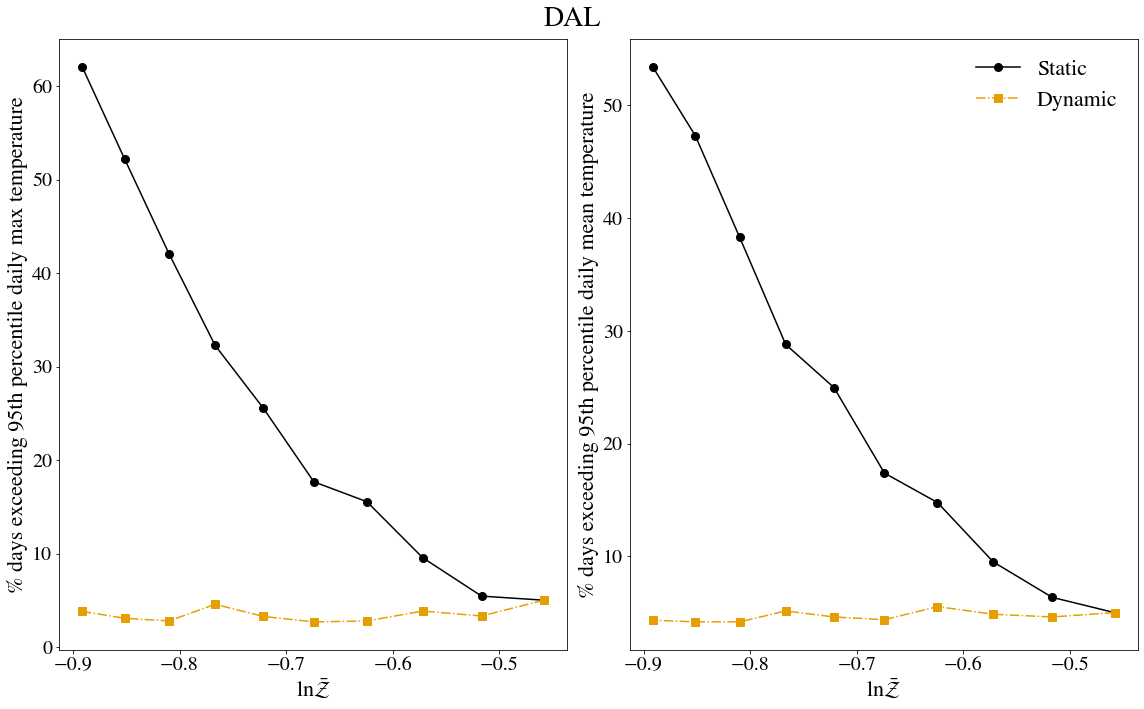

In [11]:
# location index: index of location (Follow file_list)

file_num = 1

fig, ax = plt.subplots(1,2, figsize=figsize)

ax[0].plot(np.log(Zs[file_num]), Tmax_exs_stat[file_num], marker=marker_list[0], markersize = markersize, linestyle='solid', color=color_list[0], label="Static")
ax[0].plot(np.log(Zs[file_num]), Tmax_exs_dyn[file_num], marker=marker_list[1], markersize = markersize, linestyle='dashdot', color=color_list[1], label="Dynamic")

ax[1].plot(np.log(Zs[file_num]), Tdaily_exs_stat[file_num], marker=marker_list[0], markersize = markersize, linestyle='solid', color=color_list[0], label="Static")
ax[1].plot(np.log(Zs[file_num]), Tdaily_exs_dyn[file_num], marker=marker_list[1], markersize = markersize, linestyle='dashdot', color=color_list[1], label="Dynamic")
fig.suptitle(file_list[file_num], fontsize=fontsize+6)
ax[1].legend(frameon=False, fontsize=fontsize)
ax[0].set_ylabel("% days exceeding 95th percentile daily max temperature", fontsize=fontsize)
ax[1].set_ylabel("% days exceeding 95th percentile daily mean temperature", fontsize=fontsize)

for i in range(0,2):
    ax[i].tick_params(axis="both", labelsize=labelsize)
    ax[i].set_xlabel(r"$\ln\bar{\mathcal{Z}}$", fontsize=fontsize)
    
fig.tight_layout()

### Change in 95th percentile

(Using $\log\mathcal{Z}$ scale.)

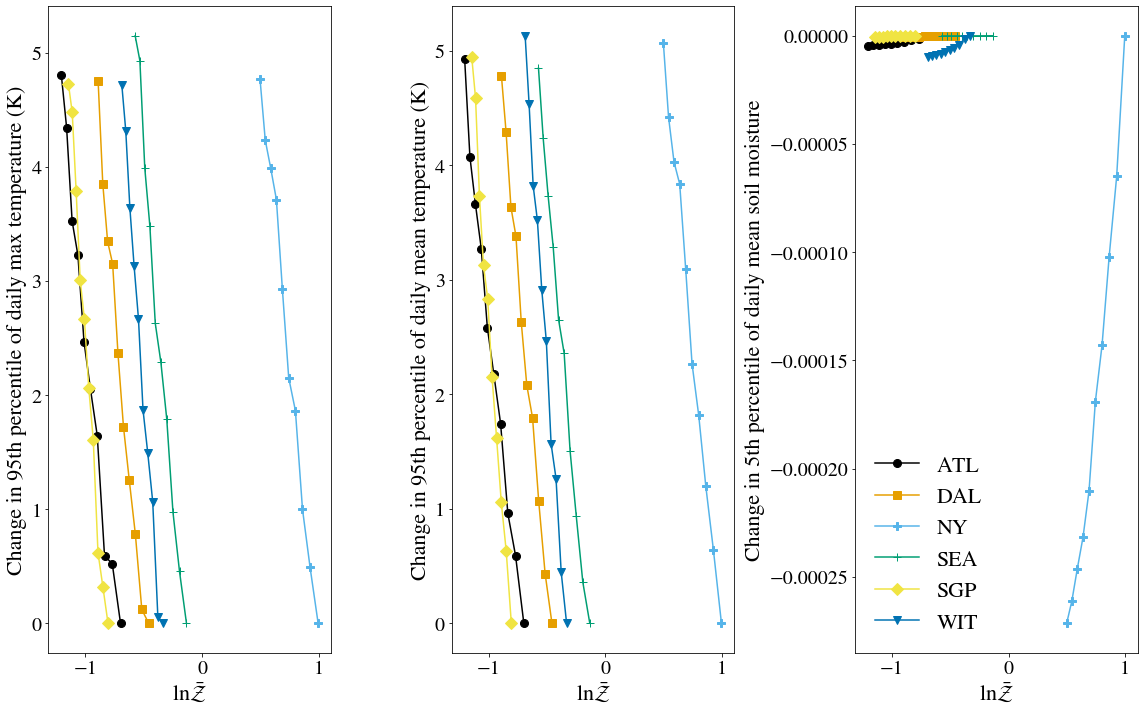

In [12]:
fig, ax = plt.subplots(1, 3, figsize=figsize)

for file in range(N_files):
    ax[0].plot(np.log(Zs[file]), Tmax_95percs[file] - Tmax_95percs[file][0], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    ax[1].plot(np.log(Zs[file]), Tdaily_95percs[file] - Tdaily_95percs[file][0], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    ax[2].plot(np.log(Zs[file]), mdaily_5percs[file] - mdaily_5percs[file][0], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    
ax[0].set_ylabel("Change in 95th percentile of daily max temperature (K)", fontsize=fontsize)
ax[1].set_ylabel("Change in 95th percentile of daily mean temperature (K)", fontsize=fontsize)
ax[2].set_ylabel("Change in 5th percentile of daily mean soil moisture", fontsize=fontsize)
ax[2].legend(frameon=False, fontsize=fontsize)

for plot in range(0, 3):
    ax[plot].tick_params(axis='both', labelsize=labelsize)
    ax[plot].set_xlabel(r"$\ln\bar{\mathcal{Z}}$", fontsize=fontsize)
    
fig.tight_layout()

### Daily Maximum Temperature Statistics

Daily max temperature mean, standard deviation and skewness as a function of $\cal{Z}$.

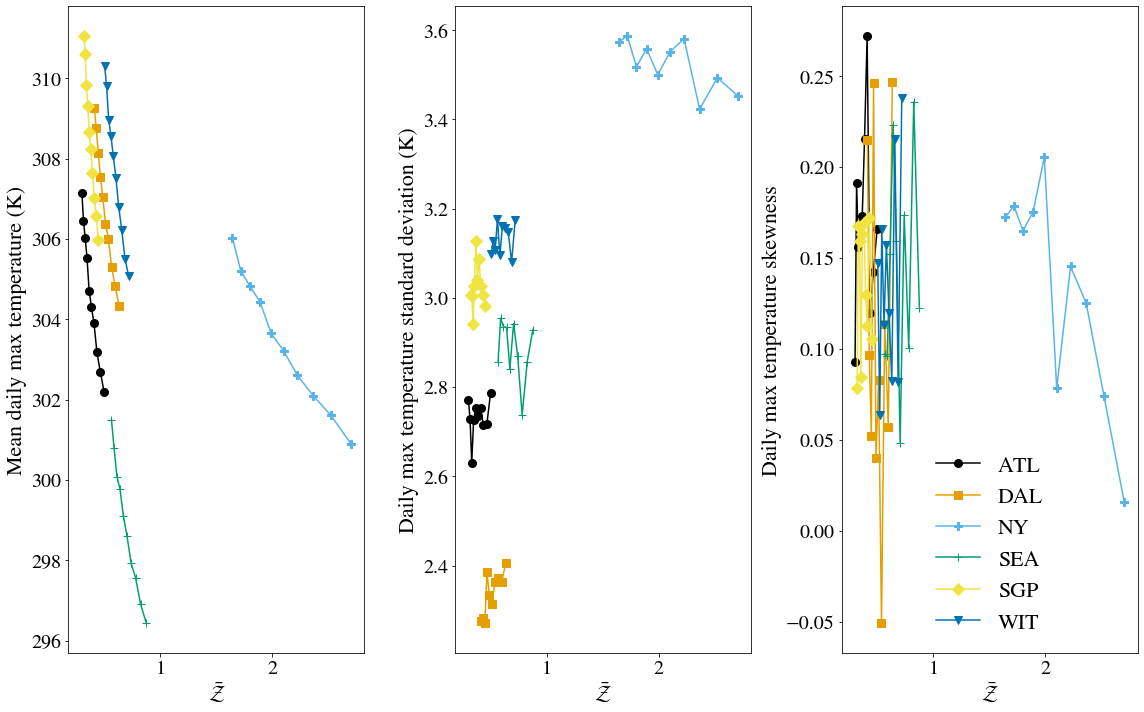

In [13]:
fig, ax = plt.subplots(1, 3, figsize=figsize)

for file in range(N_files):
    ax[0].plot(Zs[file], Tmax_mean[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    ax[1].plot(Zs[file], Tmax_std[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    ax[2].plot(Zs[file], Tmax_skew[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    
ax[0].set_ylabel("Mean daily max temperature (K)", fontsize=fontsize)
ax[1].set_ylabel("Daily max temperature standard deviation (K)", fontsize=fontsize)
ax[2].set_ylabel("Daily max temperature skewness", fontsize=fontsize)
ax[2].legend(frameon=False, fontsize=fontsize)

for plot in range(0, 3):
    ax[plot].tick_params(axis='both', labelsize=labelsize)
    ax[plot].set_xlabel(r"$\bar{\mathcal{Z}}$", fontsize=fontsize)
    
fig.tight_layout()

#### Log $\cal{Z}$ scale

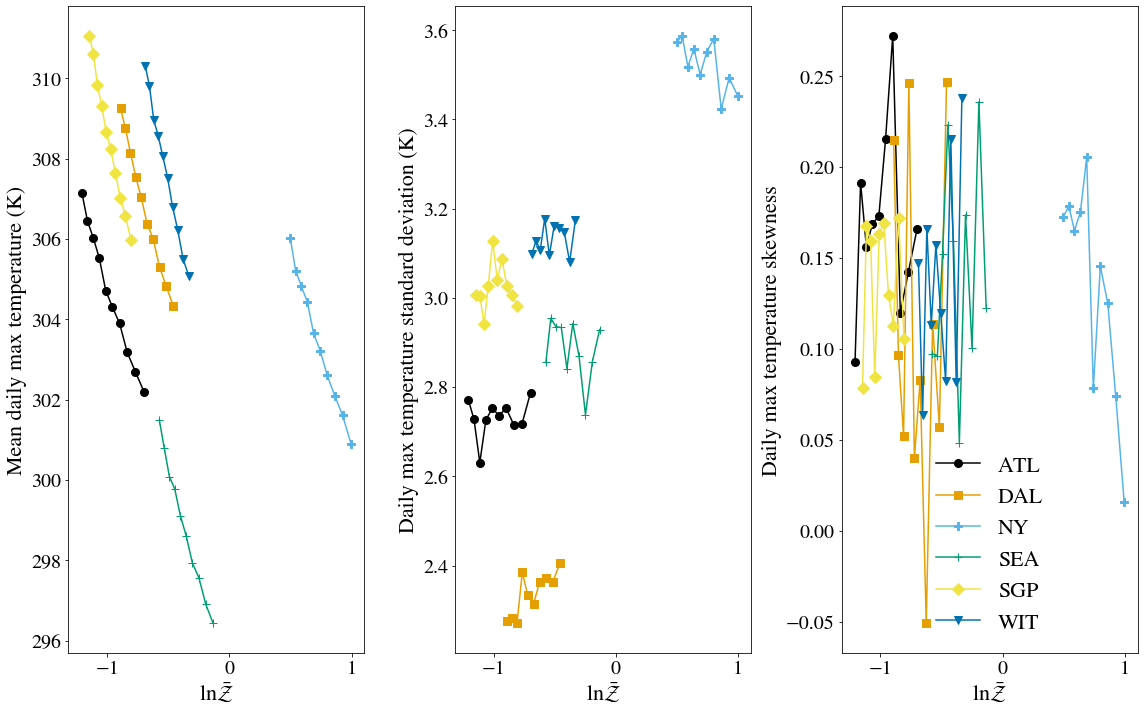

In [14]:
fig, ax = plt.subplots(1, 3, figsize=figsize)

for file in range(N_files):
    ax[0].plot(np.log(Zs[file]), Tmax_mean[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    ax[1].plot(np.log(Zs[file]), Tmax_std[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    ax[2].plot(np.log(Zs[file]), Tmax_skew[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    
ax[0].set_ylabel("Mean daily max temperature (K)", fontsize=fontsize)
ax[1].set_ylabel("Daily max temperature standard deviation (K)", fontsize=fontsize)
ax[2].set_ylabel("Daily max temperature skewness", fontsize=fontsize)
ax[2].legend(frameon=False, fontsize=fontsize)

for plot in range(0, 3):
    ax[plot].tick_params(axis='both', labelsize=labelsize)
    ax[plot].set_xlabel(r"$\ln\bar{\mathcal{Z}}$", fontsize=fontsize)
    
fig.tight_layout()

### Daily Mean Temperature Statistics

Daily mean temperature mean, standard deviation and skewness as a function of $\cal{Z}$.

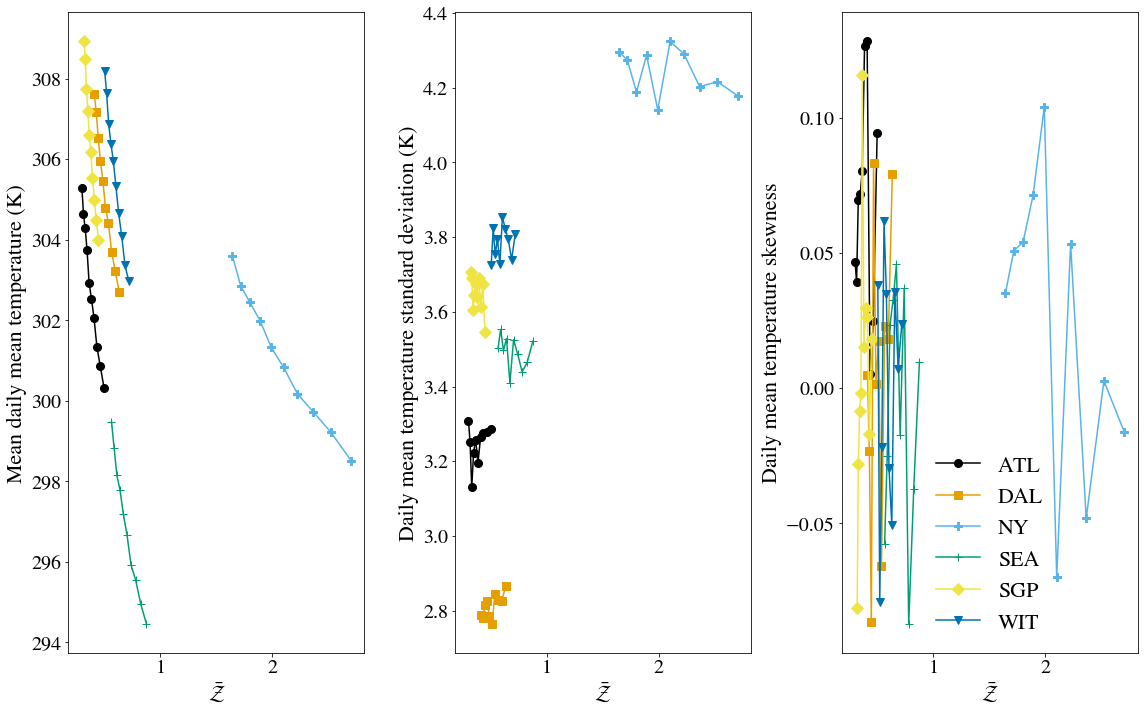

In [15]:
fig, ax = plt.subplots(1, 3, figsize=figsize)

for file in range(N_files):
    ax[0].plot(Zs[file], Tdaily_mean[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    ax[1].plot(Zs[file], Tdaily_std[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    ax[2].plot(Zs[file], Tdaily_skew[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    
ax[0].set_ylabel("Mean daily mean temperature (K)", fontsize=fontsize)
ax[1].set_ylabel("Daily mean temperature standard deviation (K)", fontsize=fontsize)
ax[2].set_ylabel("Daily mean temperature skewness", fontsize=fontsize)
ax[2].legend(frameon=False, fontsize=fontsize)

for plot in range(0, 3):
    ax[plot].tick_params(axis='both', labelsize=labelsize)
    ax[plot].set_xlabel(r"$\bar{\mathcal{Z}}$", fontsize=fontsize)
    
fig.tight_layout()

#### Log $\cal{Z}$ scale

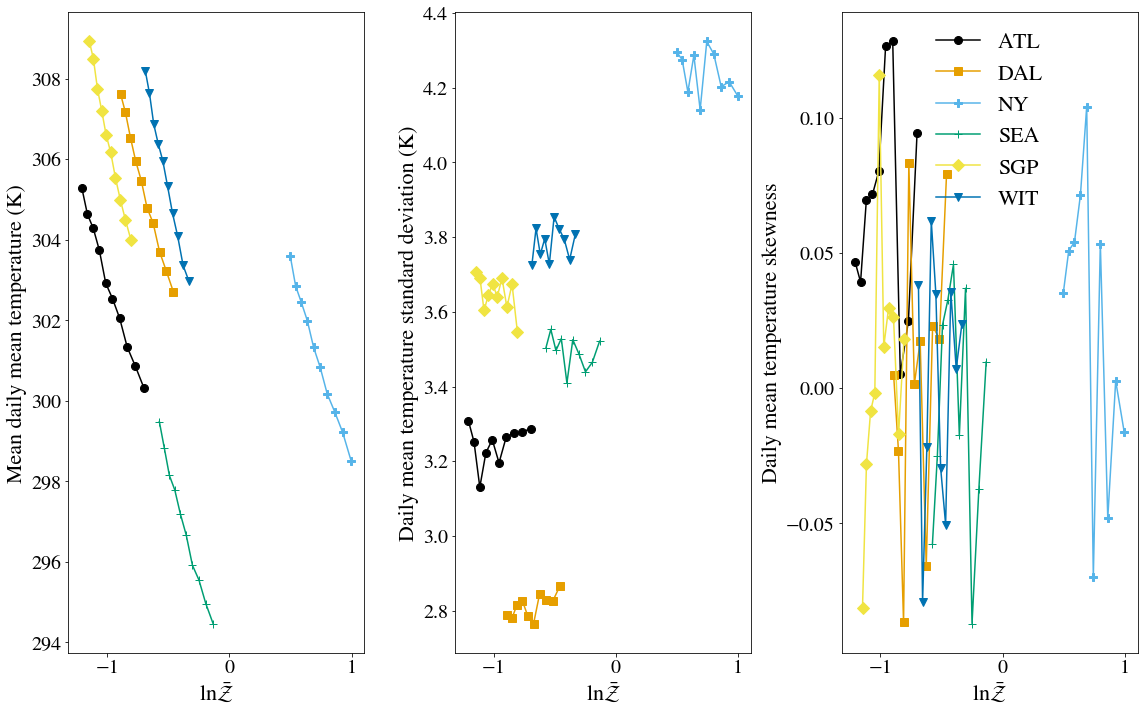

In [16]:
fig, ax = plt.subplots(1, 3, figsize=figsize)

for file in range(N_files):
    ax[0].plot(np.log(Zs[file]), Tdaily_mean[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    ax[1].plot(np.log(Zs[file]), Tdaily_std[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    ax[2].plot(np.log(Zs[file]), Tdaily_skew[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    
ax[0].set_ylabel("Mean daily mean temperature (K)", fontsize=fontsize)
ax[1].set_ylabel("Daily mean temperature standard deviation (K)", fontsize=fontsize)
ax[2].set_ylabel("Daily mean temperature skewness", fontsize=fontsize)
ax[2].legend(frameon=False, fontsize=fontsize)

for plot in range(0, 3):
    ax[plot].tick_params(axis='both', labelsize=labelsize)
    ax[plot].set_xlabel(r"$\ln\bar{\mathcal{Z}}$", fontsize=fontsize)
    
fig.tight_layout()

### Daily Mean Soil Moisture Fraction Statistics

Daily mean soil moisture fraction mean, standard deviation and skewness as a function of $\cal{Z}$.

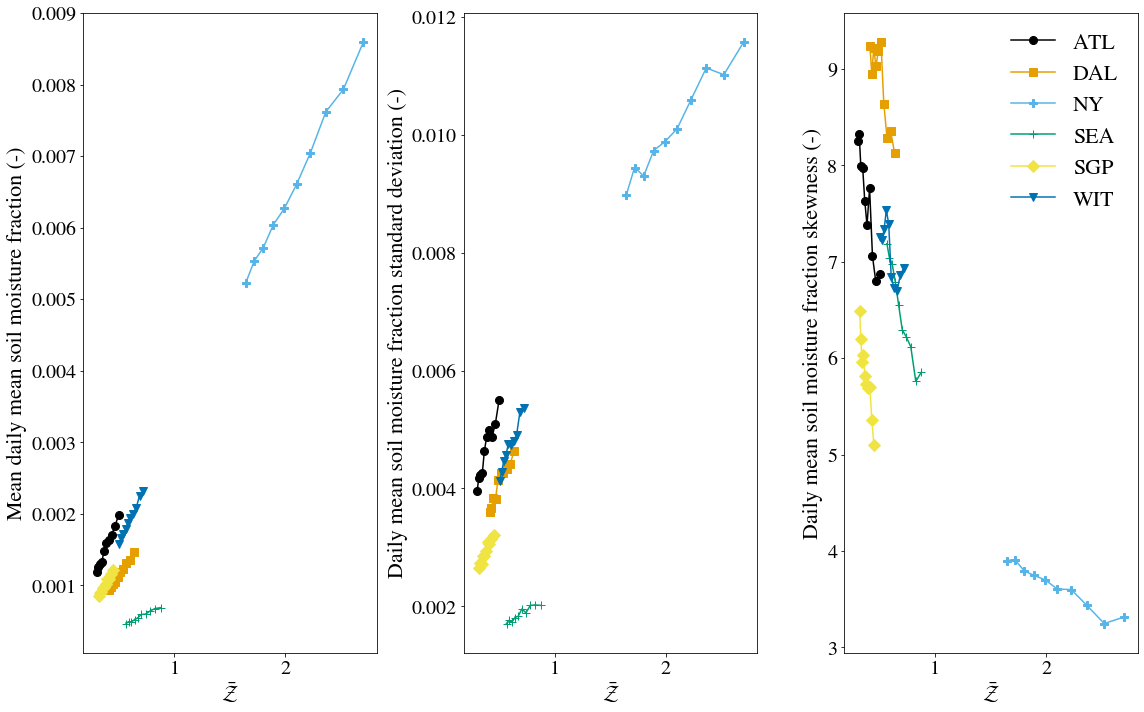

In [17]:
fig, ax = plt.subplots(1, 3, figsize=figsize)

for file in range(N_files):
    ax[0].plot(Zs[file], mdaily_mean[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    ax[1].plot(Zs[file], mdaily_std[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    ax[2].plot(Zs[file], mdaily_skew[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    
ax[0].set_ylabel("Mean daily mean soil moisture fraction (-)", fontsize=fontsize)
ax[1].set_ylabel("Daily mean soil moisture fraction standard deviation (-)", fontsize=fontsize)
ax[2].set_ylabel("Daily mean soil moisture fraction skewness (-)", fontsize=fontsize)
ax[2].legend(frameon=False, fontsize=fontsize)

for plot in range(0, 3):
    ax[plot].tick_params(axis='both', labelsize=labelsize)
    ax[plot].set_xlabel(r"$\bar{\mathcal{Z}}$", fontsize=fontsize)
    
fig.tight_layout()

#### Log $\cal{Z}$ scale

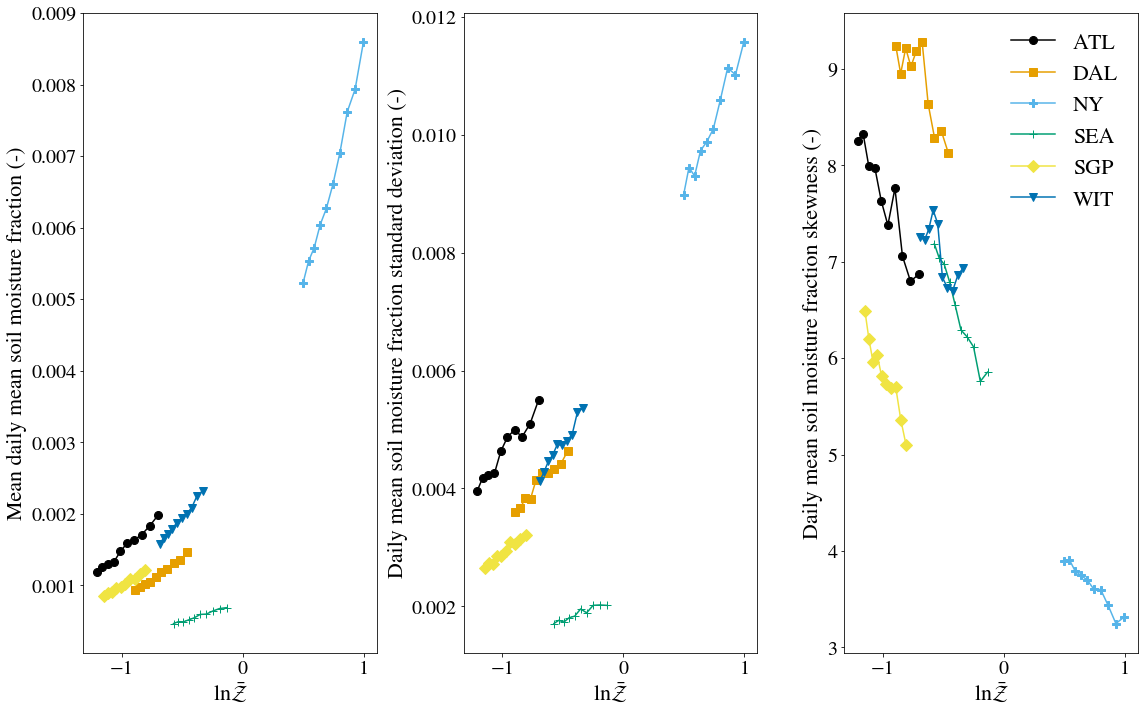

In [18]:
fig, ax = plt.subplots(1, 3, figsize=figsize)

for file in range(N_files):
    ax[0].plot(np.log(Zs[file]), mdaily_mean[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    ax[1].plot(np.log(Zs[file]), mdaily_std[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    ax[2].plot(np.log(Zs[file]), mdaily_skew[file], color=color_list[file], markersize = markersize, marker=marker_list[file], label=file_list[file])
    
ax[0].set_ylabel("Mean daily mean soil moisture fraction (-)", fontsize=fontsize)
ax[1].set_ylabel("Daily mean soil moisture fraction standard deviation (-)", fontsize=fontsize)
ax[2].set_ylabel("Daily mean soil moisture fraction skewness (-)", fontsize=fontsize)
ax[2].legend(frameon=False, fontsize=fontsize)

for plot in range(0, 3):
    ax[plot].tick_params(axis='both', labelsize=labelsize)
    ax[plot].set_xlabel(r"$\ln\bar{\mathcal{Z}}$", fontsize=fontsize)
    
fig.tight_layout()

## Histograms and PDFs

In this section, we plot up some raw histograms of daily max temperature, daily mean temperature, and daily mean soil moisture in the different simulations. 

### Daily max temperature histograms

Histograms of daily max temperature in the base case and the final simulation. 

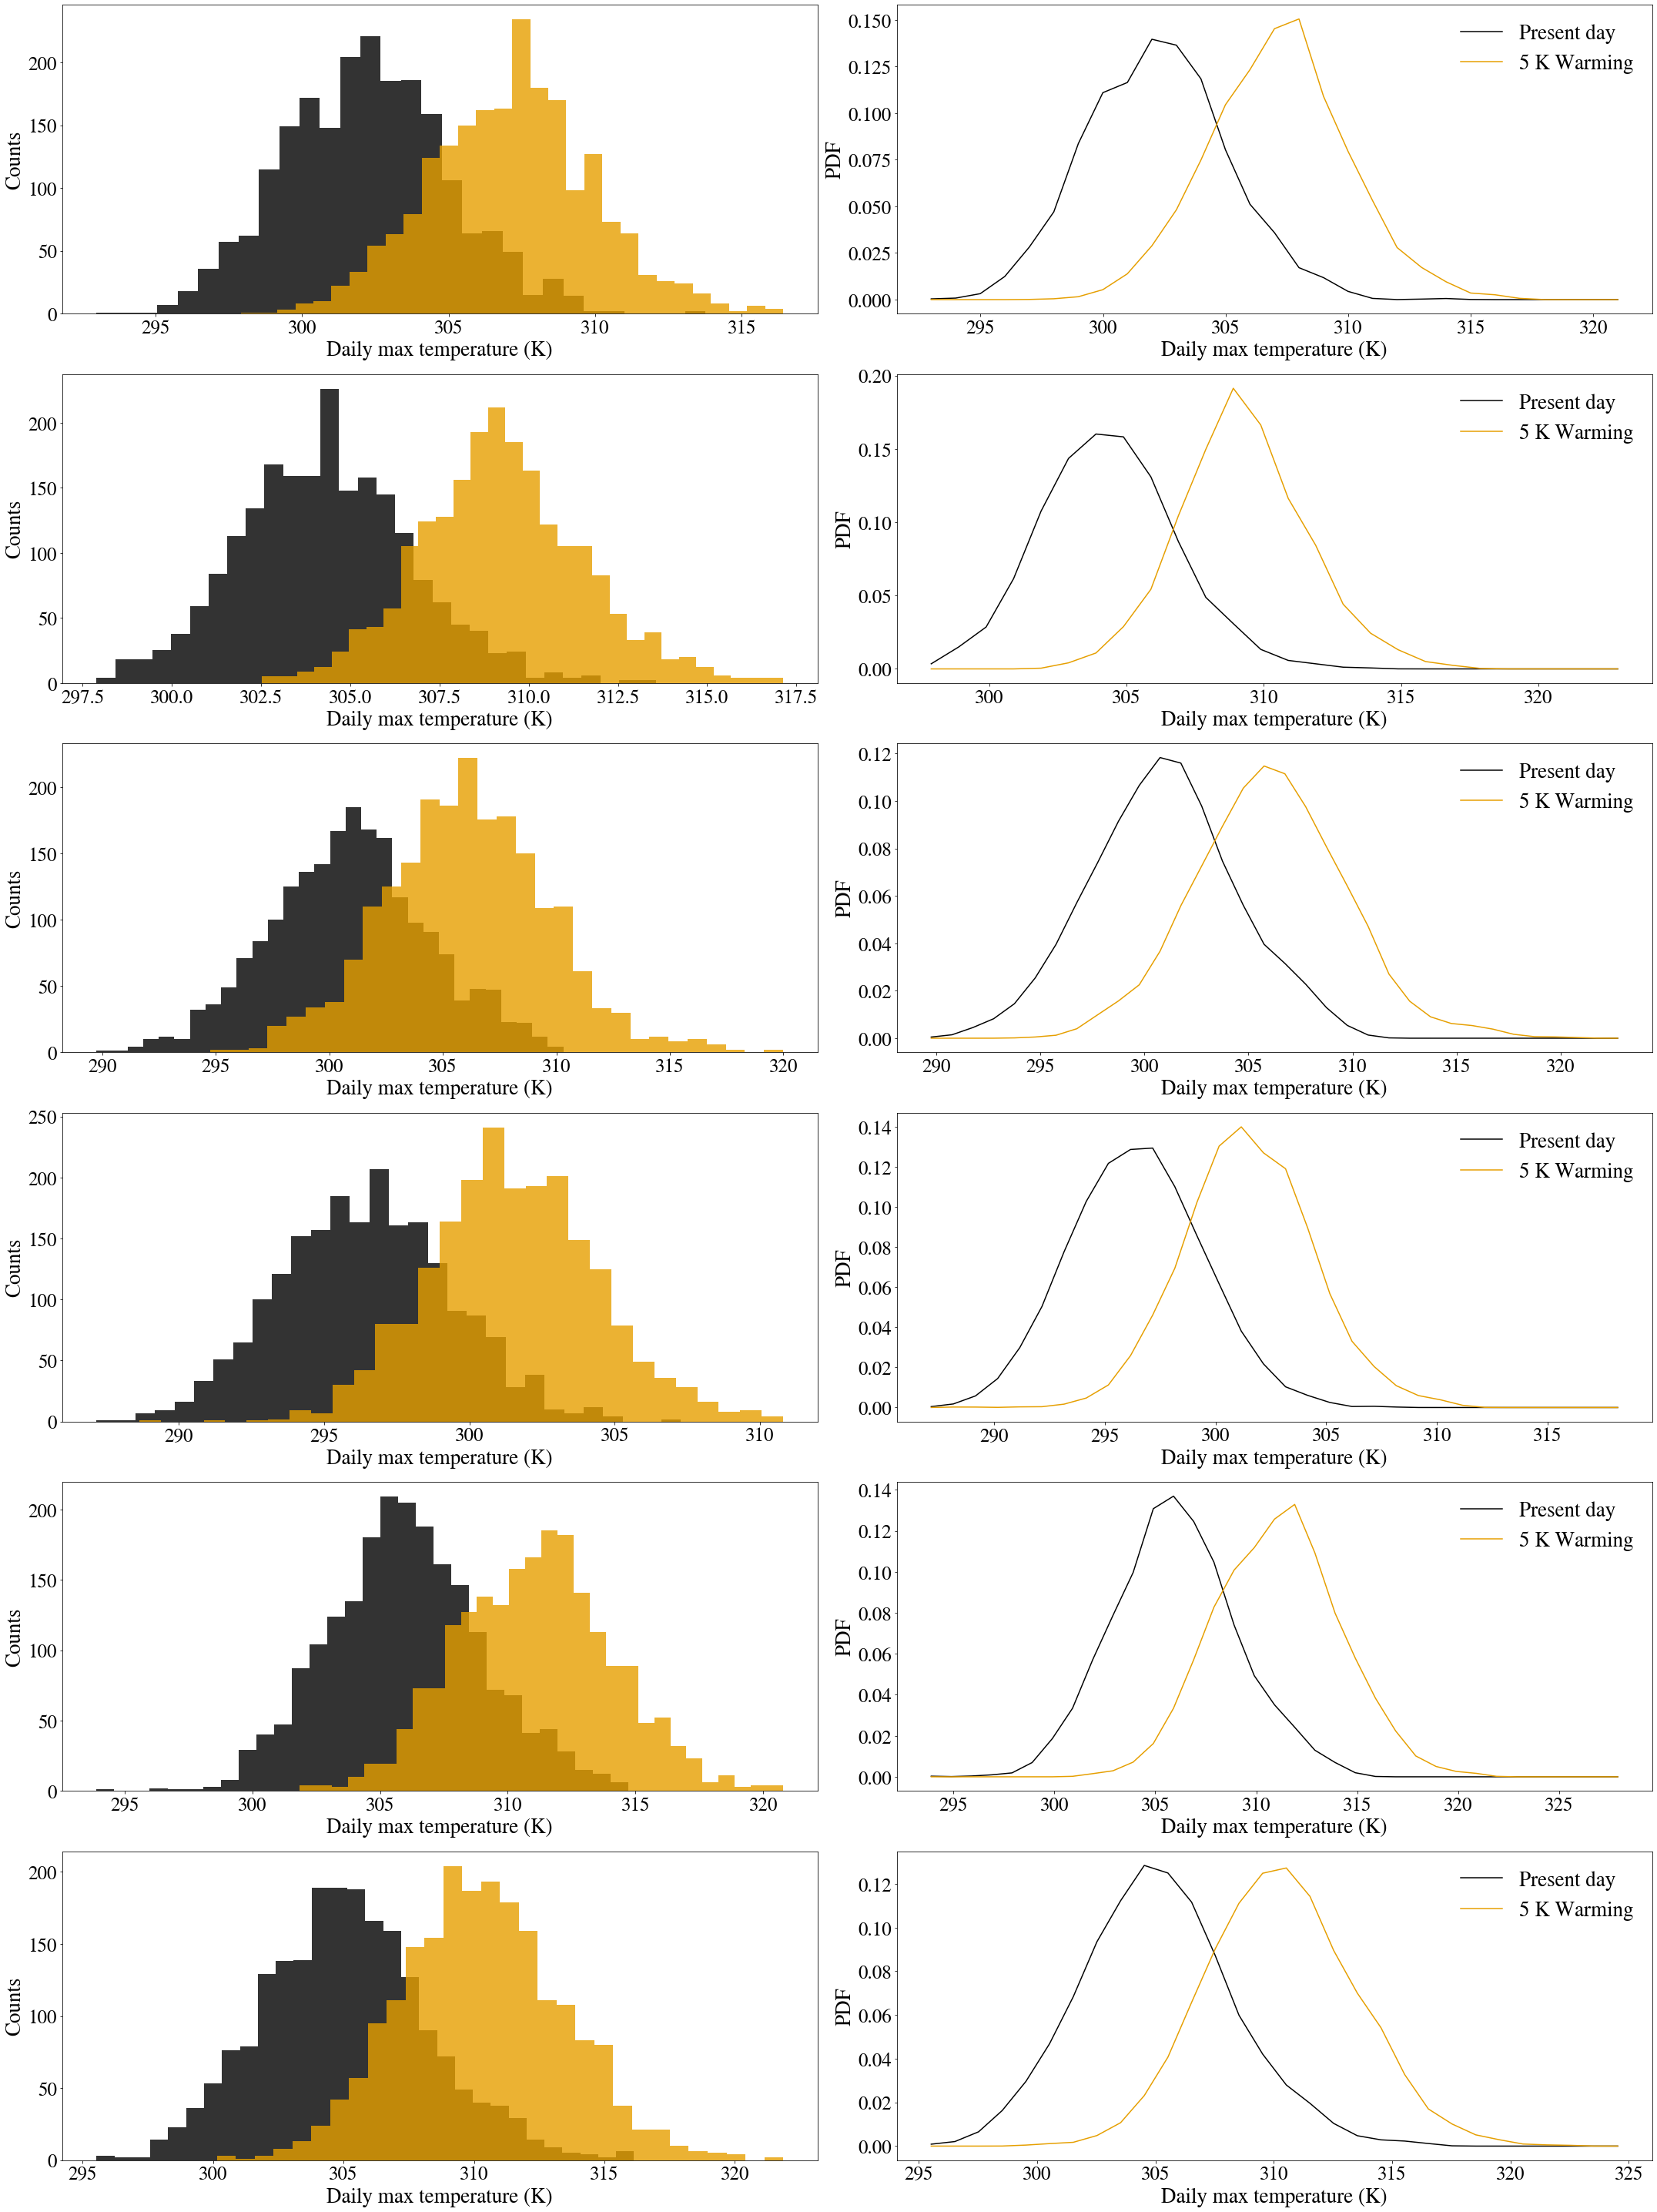

In [19]:
fig, ax = plt.subplots(N_files, 2, figsize=(30,40))

fontsize = fontsize + 5
labelsize = labelsize + 5

base_pdfs = [gaussian_kde(Tmax_daily[file][0]) for file in range(N_files)]
max_pdfs = [gaussian_kde(Tmax_daily[file][-1]) for file in range(N_files)]

for file in range(N_files):
    ax[file, 0].hist(Tmax_daily[file][0], bins=30, color=color_list[0], label="Present day", alpha=0.8)
    ax[file, 0].hist(Tmax_daily[file][-1], bins=30, color=color_list[1], label="5 K Warming", alpha=0.8)
    
    tmp_temp = np.arange(min(Tmax_daily[file][0]), max(Tmax_daily[file][1]) + 10)
    ax[file, 1].plot(tmp_temp, base_pdfs[file](tmp_temp), color=color_list[0], label="Present day")
    ax[file, 1].plot(tmp_temp, max_pdfs[file](tmp_temp), color=color_list[1], label="5 K Warming")
    
    ax[file, 1].legend(frameon=False, fontsize=fontsize)
    
    ax[file, 0].set_ylabel("Counts", fontsize=fontsize)
    ax[file, 0].set_xlabel("Daily max temperature (K)", fontsize=fontsize)
    
    ax[file, 1].set_ylabel("PDF", fontsize=fontsize)
    ax[file, 1].set_xlabel("Daily max temperature (K)", fontsize=fontsize)
    
    ax[file, 0].tick_params(axis="both", labelsize=labelsize)
    ax[file, 1].tick_params(axis="both", labelsize=labelsize)
    
fig.tight_layout()

### Daily mean temperature histograms

Histograms of daily mean temperature in the base case and the final simulation. 

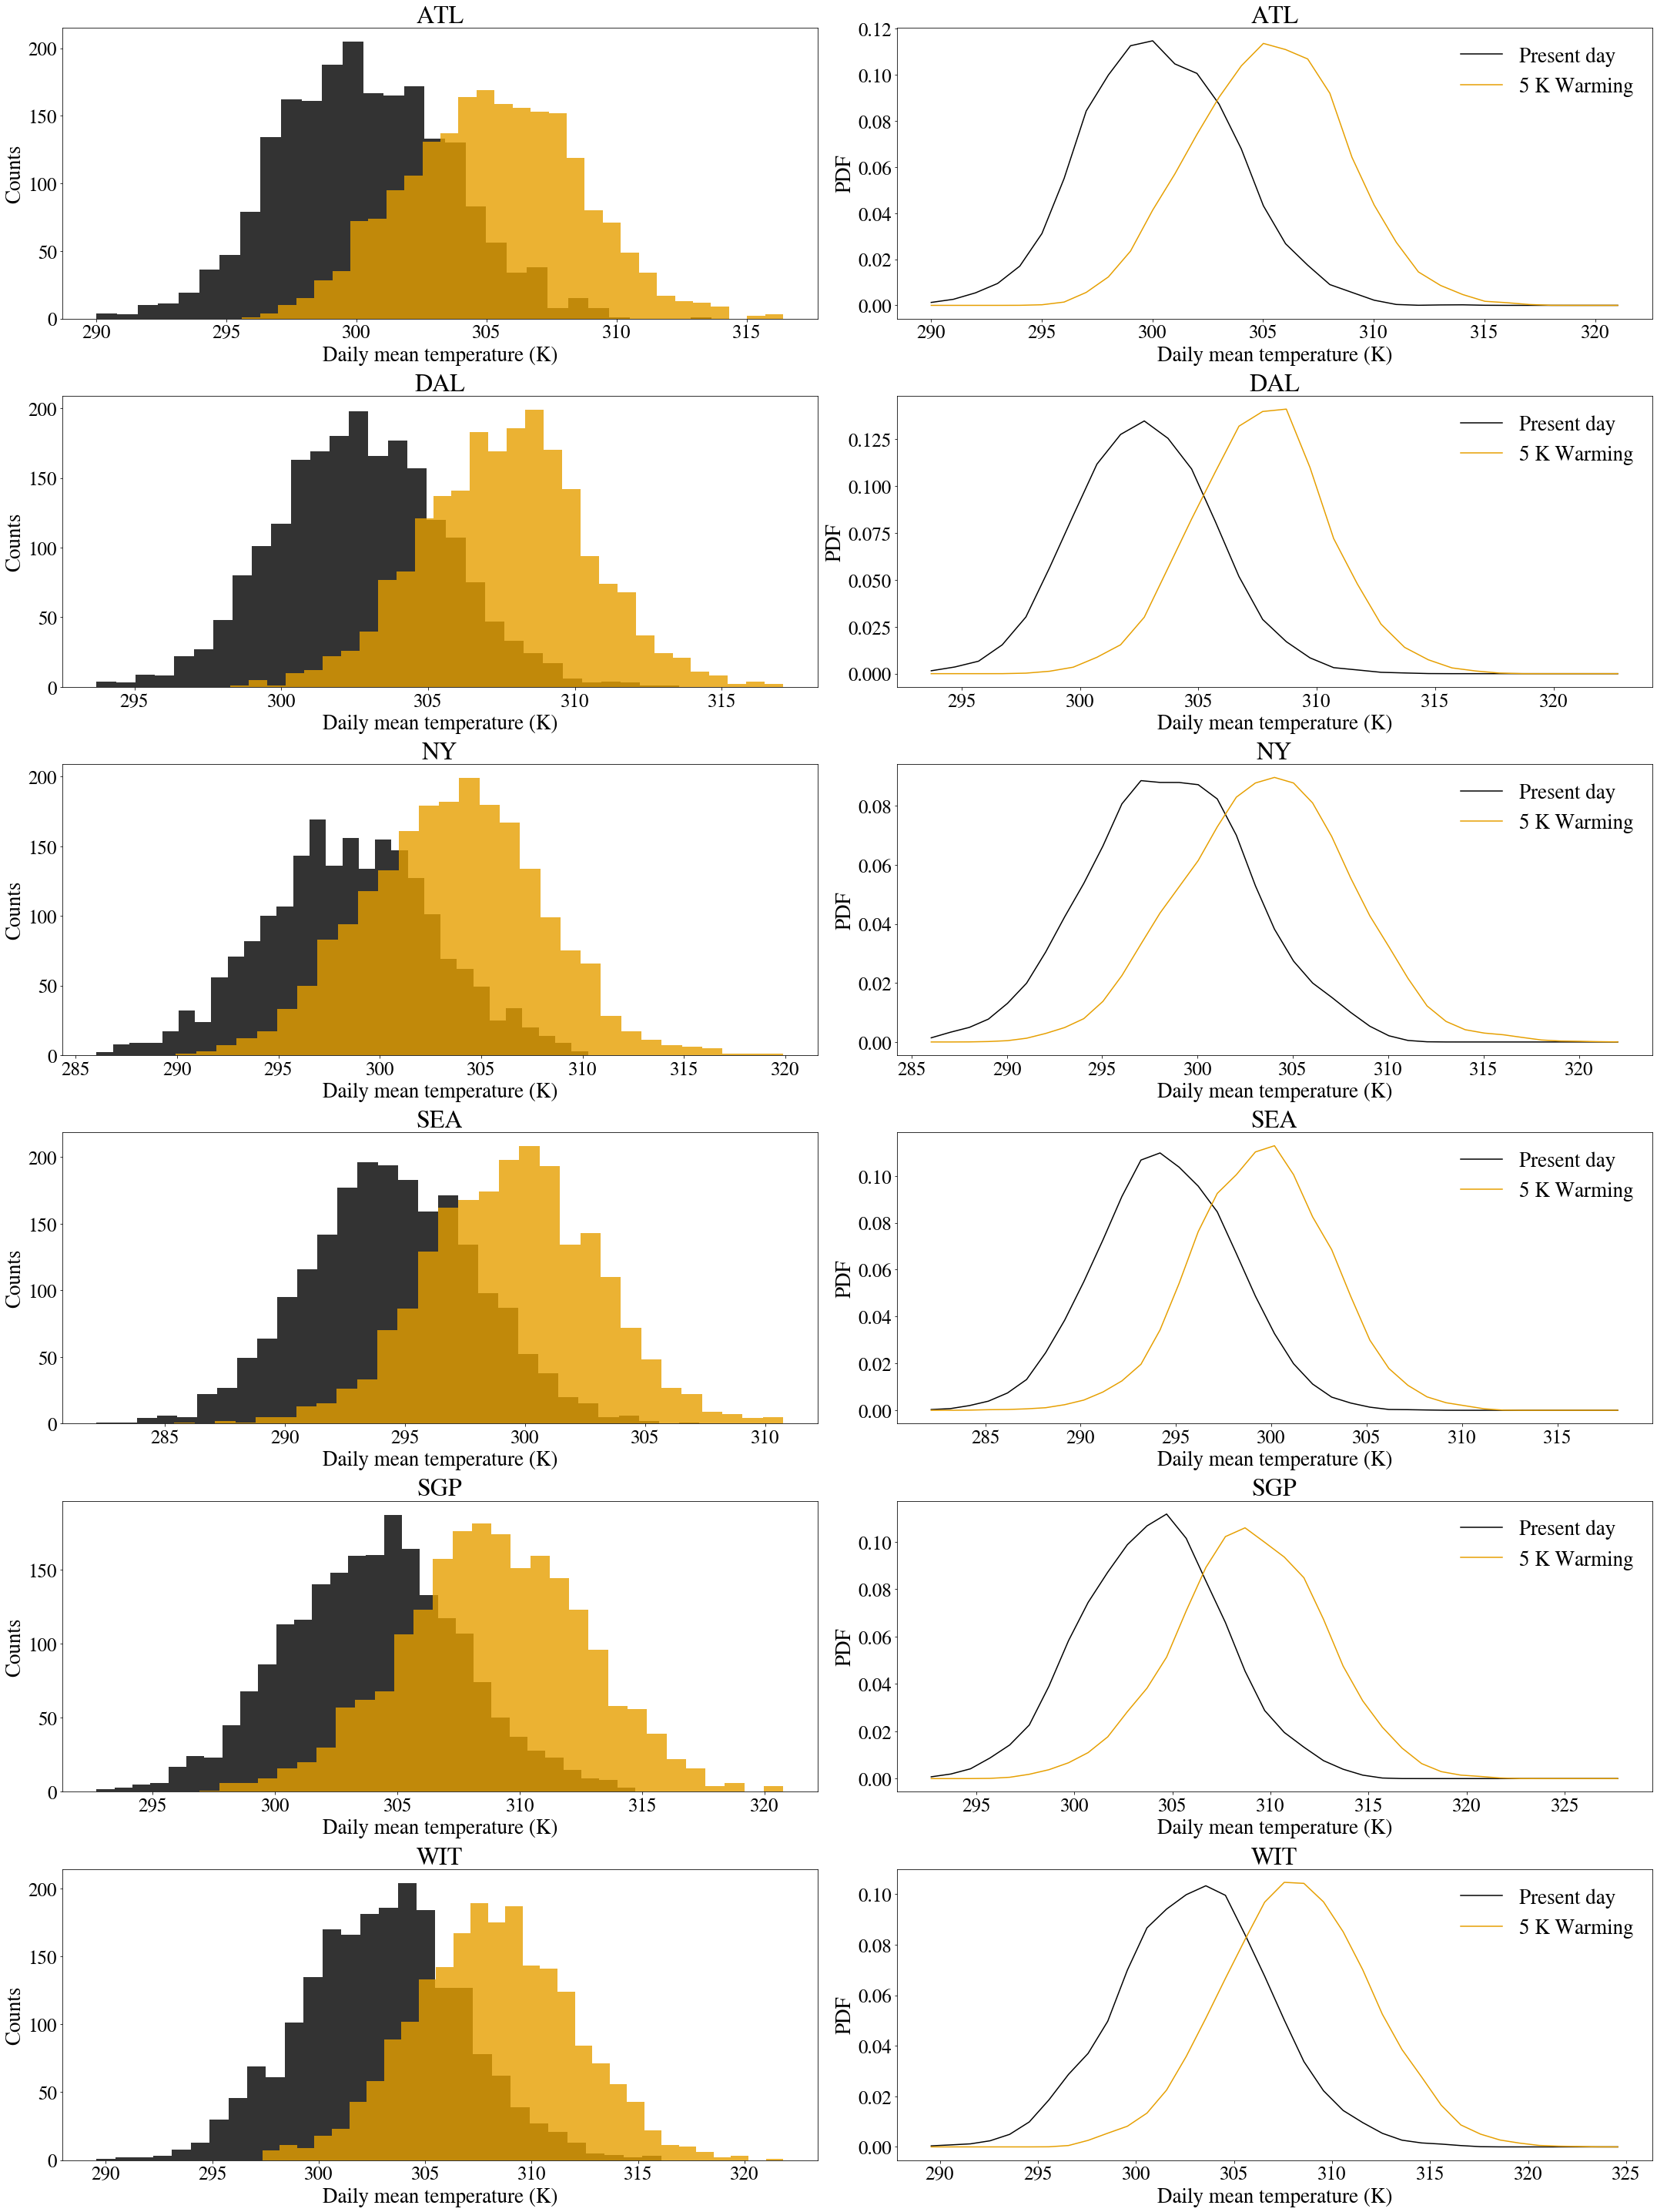

In [20]:
fig, ax = plt.subplots(N_files, 2, figsize=(30,40))

base_pdfs = [gaussian_kde(Tdaily_daily[file][0]) for file in range(N_files)]
max_pdfs = [gaussian_kde(Tdaily_daily[file][-1]) for file in range(N_files)]

for file in range(N_files):
    ax[file, 0].hist(Tdaily_daily[file][0], bins=30, color=color_list[0], label="Present day", alpha=0.8)
    ax[file, 0].hist(Tdaily_daily[file][-1], bins=30, color=color_list[1], label="5 K Warming", alpha=0.8)
    
    tmp_temp = np.arange(min(Tdaily_daily[file][0]), max(Tdaily_daily[file][1]) + 10)
    ax[file, 1].plot(tmp_temp, base_pdfs[file](tmp_temp), color=color_list[0], label="Present day")
    ax[file, 1].plot(tmp_temp, max_pdfs[file](tmp_temp), color=color_list[1], label="5 K Warming")
    
    ax[file, 1].legend(frameon=False, fontsize=fontsize)
    
    ax[file, 0].set_title(file_list[file], fontsize=fontsize + 5)
    ax[file, 1].set_title(file_list[file], fontsize=fontsize + 5)

    
    ax[file, 0].set_ylabel("Counts", fontsize=fontsize)
    ax[file, 0].set_xlabel("Daily mean temperature (K)", fontsize=fontsize)
    
    ax[file, 1].set_ylabel("PDF", fontsize=fontsize)
    ax[file, 1].set_xlabel("Daily mean temperature (K)", fontsize=fontsize)
    
    ax[file, 0].tick_params(axis="both", labelsize=labelsize)
    ax[file, 1].tick_params(axis="both", labelsize=labelsize)
    
fig.tight_layout()

### Daily mean soil moisture fraction histograms

Histograms of daily mean soil moisture fraction in the base case and in the final simulation.

In [ ]:
# it goes ATL, DAL, NY, SGP, SEA, WIT
theta_maxs = [0.51222605 ]
theta_mins = [0.26186562, 0.23744649]



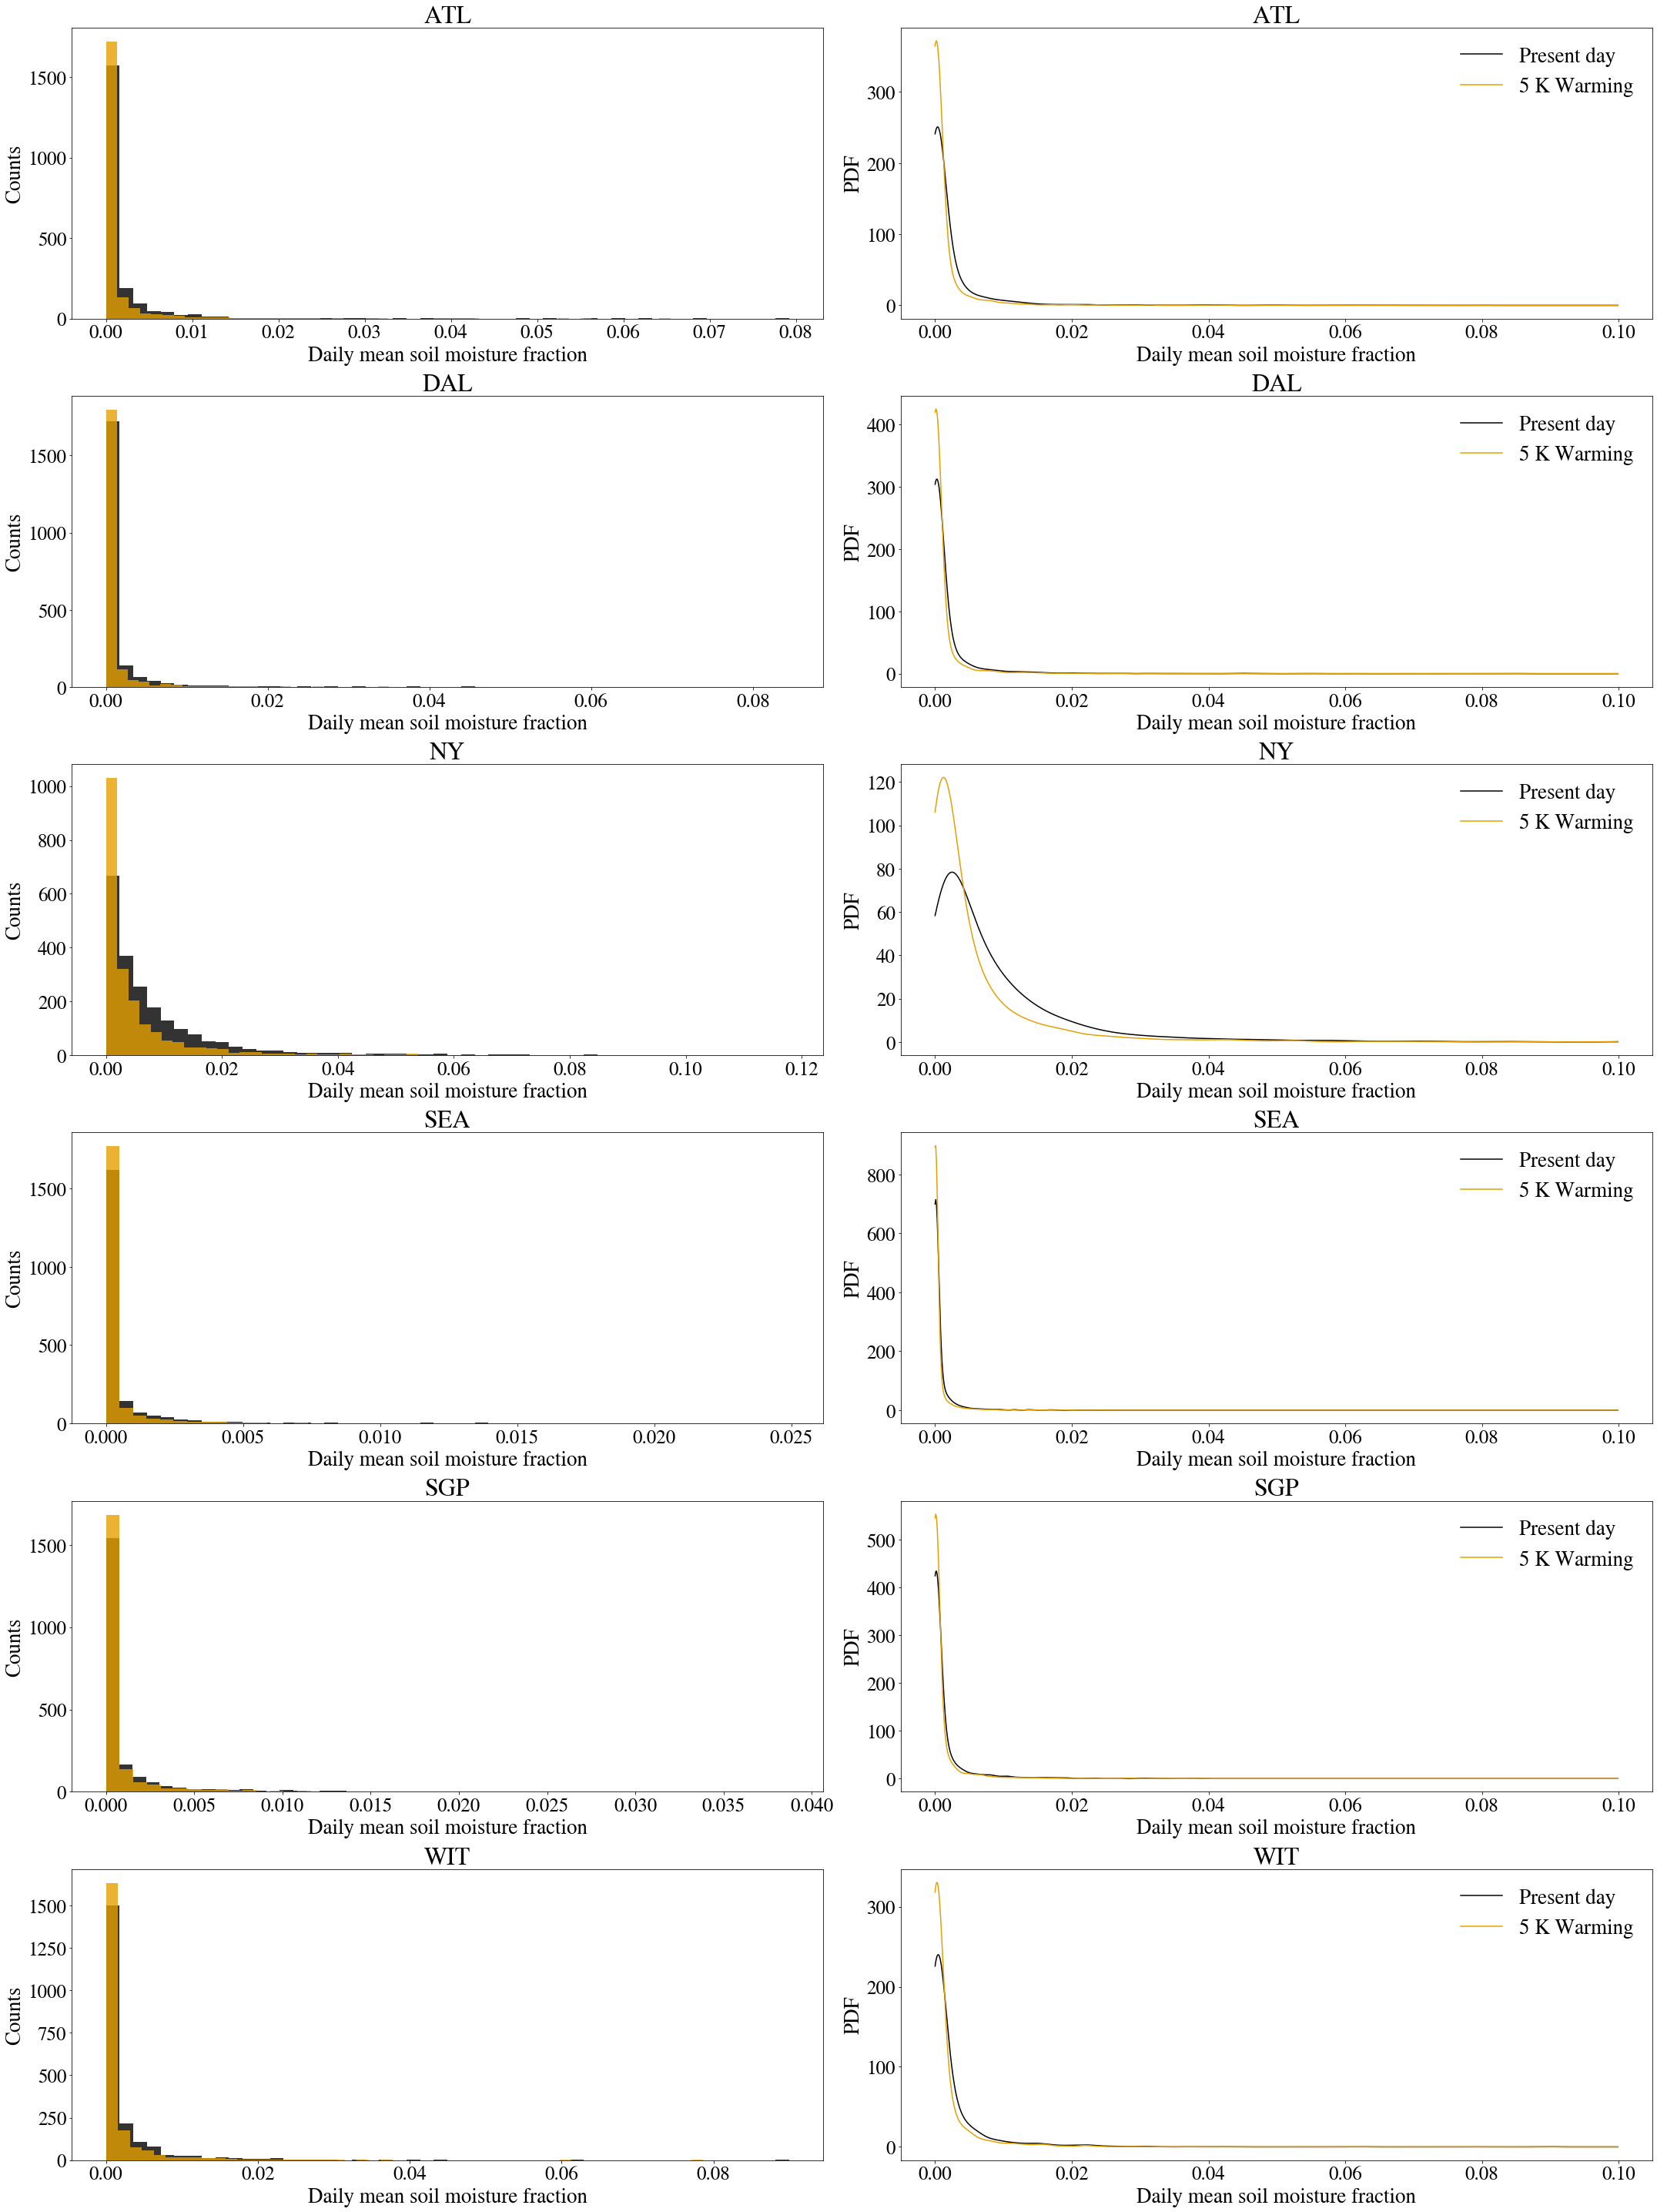

In [21]:
fig, ax = plt.subplots(N_files, 2, figsize=(30,40))

base_pdfs = [gaussian_kde(mdaily_daily[file][0]) for file in range(N_files)]
max_pdfs = [gaussian_kde(mdaily_daily[file][-1]) for file in range(N_files)]

for file in range(N_files):
    ax[file, 0].hist(mdaily_daily[file][0], bins=50, color=color_list[0], label="Present day", alpha=0.8)
    ax[file, 0].hist(mdaily_daily[file][-1], bins=50, color=color_list[1], label="5 K Warming", alpha=0.8)
    
    tmp_sm = np.arange(0,0.1, 10**(-4))
    ax[file, 1].plot(tmp_sm, base_pdfs[file](tmp_sm), color=color_list[0], label="Present day")
    ax[file, 1].plot(tmp_sm, max_pdfs[file](tmp_sm), color=color_list[1], label="5 K Warming")
    
    ax[file, 1].legend(frameon=False, fontsize=fontsize)
    
    ax[file, 0].set_title(file_list[file], fontsize=fontsize + 5)
    ax[file, 1].set_title(file_list[file], fontsize=fontsize + 5)

    
    ax[file, 0].set_ylabel("Counts", fontsize=fontsize)
    ax[file, 0].set_xlabel("Daily mean soil moisture fraction", fontsize=fontsize)
    
    ax[file, 1].set_ylabel("PDF", fontsize=fontsize)
    ax[file, 1].set_xlabel("Daily mean soil moisture fraction", fontsize=fontsize)
    
    ax[file, 0].tick_params(axis="both", labelsize=labelsize)
    ax[file, 1].tick_params(axis="both", labelsize=labelsize)
    
fig.tight_layout()

## Calc mean soil moisture 


In [22]:
import glob 
import numpy as np
import xarray as xr

ts_files = glob.glob("/data/keeling/a/cristi/a/data/*ts.nc*")

In [23]:
ts_files

['/data/keeling/a/cristi/a/data/2-25-2022-SGP-F-ts.nc',
 '/data/keeling/a/cristi/a/data/2-25-2022-SEA-F-ts.nc',
 '/data/keeling/a/cristi/a/data/2-25-2022-NY-F-ts.nc',
 '/data/keeling/a/cristi/a/data/2-25-2022-DAL-F-ts.nc',
 '/data/keeling/a/cristi/a/data/2-25-2022-ATL-F-ts.nc',
 '/data/keeling/a/cristi/a/data/2-25-2022-WIT-F-ts.nc',
 '/data/keeling/a/cristi/a/data/3-4-2022-SEA-full-ts.nc',
 '/data/keeling/a/cristi/a/data/3-4-2022-NY-full-ts.nc',
 '/data/keeling/a/cristi/a/data/3-4-2022-DAL-full-ts.nc',
 '/data/keeling/a/cristi/a/data/3-4-2022-SGP-full-ts.nc',
 '/data/keeling/a/cristi/a/data/3-4-2022-WIT-full-ts.nc',
 '/data/keeling/a/cristi/a/data/3-4-2022-ATL-full-ts.nc']

In [24]:
for file in ts_files:
    print(file)
    tmp_ds = xr.open_dataset(file)
    tmp_m = ds['m_ts'].values
    tmp_base_m = tmp_m[0, :]
    tmp_mean_m = np.mean(tmp_base_m)
    print(ds['m_ts'].mean(axis=1)[0].values)

/data/keeling/a/cristi/a/data/2-25-2022-SGP-F-ts.nc


KeyError: 'm_ts'

In [ ]:
phobe = 5
ds = xr.open_dataset(ts_files[phobe])
ds, ts_files[phobe]

In [ ]:
m = ds['m_ts'].mean(axis=1)
m